In [25]:
# Import the numpy and pandas packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np   
import pandas as pd

#ploting 
import matplotlib.pyplot as plt
import seaborn as sns  

#To split and encoding data 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import cross_validation

#machine learning algorthms
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

In [26]:
#Loading data
train = pd.read_csv("training titanic.csv")
test = pd.read_csv("test_titanic.csv")



In [27]:
print(train.info())
print(test.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null 

As the cabin doesn't have sufficient data.. we choose to drop it and droping unnecessary columns which are not useful

In [28]:
#To drop data
train = train.drop(['Name','Ticket','Cabin'],axis = 1)
test = test.drop(['Name','Ticket','Cabin'],axis = 1)


In [29]:
#filling nulls with median
train['Age'] = train['Age'].fillna(train.Age.median(axis=0))
test['Age'] = test['Age'].fillna(test.Age.median(axis=0))
#[train.Age.fillna(train.Age.median(),inplace=True) for Age in train.columns]


In [30]:
#Feature engineeering 
#Adding 2 new columns familysize and IsAlone
train['FamilySize'] = train ['SibSp'] + train['Parch'] + 1
train['IsAlone'] = 1 #initialize to yes/1 is alone
train['IsAlone'].loc[train['FamilySize'] > 1] = 0 
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
test['IsAlone'] = 1 #initialize to yes/1 is alone
test['IsAlone'].loc[test['FamilySize'] > 1] = 0 


In [31]:
#Farebin
#Binnig Age and Fare
train['FareBin'] = pd.qcut(train['Fare'], 8)
test['FareBin'] = pd.qcut(test['Fare'], 8)
train['AgeBin'] = pd.cut(train['Age'].astype(int), 8)
test['AgeBin'] = pd.cut(test['Age'].astype(int), 8)


In [32]:
#Encoding

train["Embarked"] = train["Embarked"].astype('category')
test["Embarked"] = test["Embarked"].astype('category')
test["FareBin"] = test["FareBin"].astype('category')

label = LabelEncoder()

train['Sex_Code'] = label.fit_transform(train['Sex'])
train['AgeBin_Code'] = label.fit_transform(train['AgeBin'])
train['FareBin_Code'] = label.fit_transform(train['FareBin'])

test['Sex_Code'] = label.fit_transform(test['Sex'])
test['AgeBin_Code'] = label.fit_transform(test['AgeBin'])

test["FareBin_Code"] = test["FareBin"].cat.codes
train["Embarked_Code"] = train["Embarked"].cat.codes
test["Embarked_Code"] = test["Embarked"].cat.codes

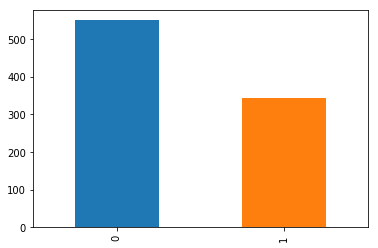

In [33]:
fig, ax = plt.subplots()
train['Survived'].value_counts().plot(ax=ax, kind='bar')


In [34]:
# bin1 = train[(train.Age >= 1) & (train.Age <= 10)]["PassengerId"]
# train.loc[bin1.index, 'agebin'] = "10"

# bin2 = train[(train.Age >= 11) & (train.Age <= 20)]["PassengerId"]
# train.loc[bin2.index, 'agebin'] = "20"

# bin3 = train[(train.Age >= 21) & (train.Age <= 30)]["PassengerId"]
# train.loc[bin3.index, 'agebin'] = "30"

# bin4 = train[(train.Age >= 31) & (train.Age <= 40)]["PassengerId"]
# train.loc[bin4.index, 'agebin'] = "40"

# bin5 = train[(train.Age >= 41) & (train.Age <= 50)]["PassengerId"]
# train.loc[bin5.index, 'agebin'] = "50"

# bin6 = train[(train.Age >= 51) & (train.Age <= 60)]["PassengerId"]
# train.loc[bin6.index, 'agebin'] = "60"

# bin7 = train[(train.Age >= 61) & (train.Age <= 70)]["PassengerId"]
# train.loc[bin7.index, 'agebin'] = "70"
    
# fig, ax = plt.subplots()
# train['agebin'].value_counts().plot(ax=ax, kind='bar')


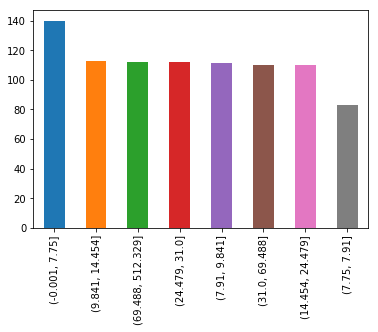

In [35]:
fig, ax = plt.subplots()
train['FareBin'].value_counts().plot(ax=ax, kind='bar')


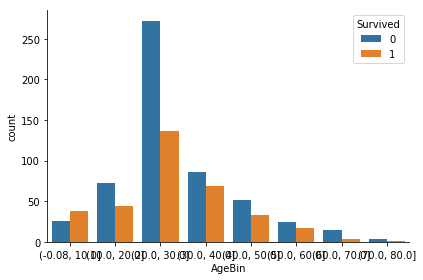

In [36]:
#overall trips 
sns.countplot(x= 'AgeBin',hue = 'Survived',data = train)
sns.despine()
plt.tight_layout()

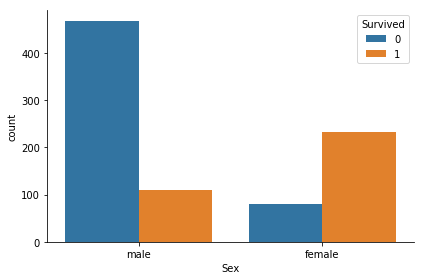

In [37]:
#overall trips 
sns.countplot(x= 'Sex',hue = 'Survived',data = train)
sns.despine()
plt.tight_layout()

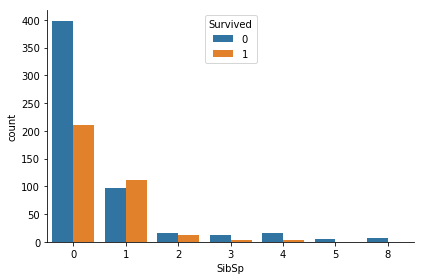

In [38]:
#overall trips 
sns.countplot(x= 'SibSp',hue = 'Survived',data = train)
sns.despine()
plt.tight_layout()

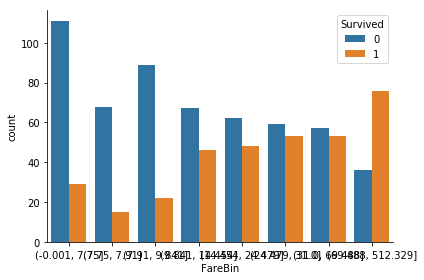

In [39]:
sns.countplot(x= 'FareBin',hue = 'Survived',data = train)
sns.despine()
plt.tight_layout()

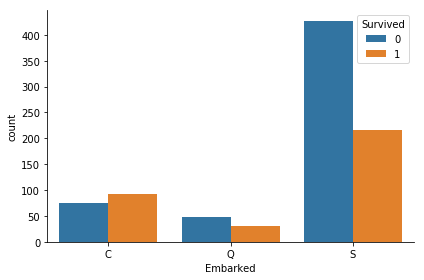

In [40]:
sns.countplot(x= 'Embarked',hue = 'Survived',data = train)
sns.despine()
plt.tight_layout()

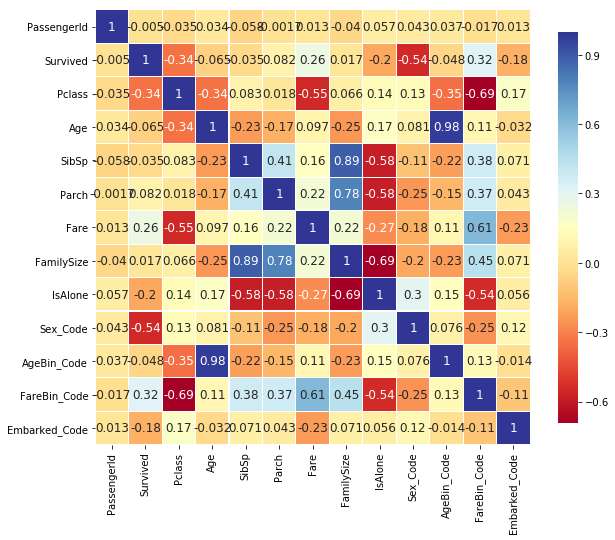

In [41]:
plt.figure(figsize=(10,8))

sns.heatmap(
        train.corr(), 
        cmap = "RdYlBu",
        square=True, 
        cbar_kws={'shrink':.9 }, 
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
plt.show()

In [42]:
train.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,FareBin,AgeBin,Sex_Code,AgeBin_Code,FareBin_Code,Embarked_Code
0,1,0,3,male,22.0,1,0,7.2500,S,2,0,"(-0.001, 7.75]","(20.0, 30.0]",1,2,0,2
1,2,1,1,female,38.0,1,0,71.2833,C,2,0,"(69.488, 512.329]","(30.0, 40.0]",0,3,7,0
2,3,1,3,female,26.0,0,0,7.9250,S,1,1,"(7.91, 9.841]","(20.0, 30.0]",0,2,2,2
3,4,1,1,female,35.0,1,0,53.1000,S,2,0,"(31.0, 69.488]","(30.0, 40.0]",0,3,6,2
4,5,0,3,male,35.0,0,0,8.0500,S,1,1,"(7.91, 9.841]","(30.0, 40.0]",1,3,2,2
5,6,0,3,male,28.0,0,0,8.4583,Q,1,1,"(7.91, 9.841]","(20.0, 30.0]",1,2,2,1
6,7,0,1,male,54.0,0,0,51.8625,S,1,1,"(31.0, 69.488]","(50.0, 60.0]",1,5,6,2
7,8,0,3,male,2.0,3,1,21.0750,S,5,0,"(14.454, 24.479]","(-0.08, 10.0]",1,0,4,2
8,9,1,3,female,27.0,0,2,11.1333,S,3,0,"(9.841, 14.454]","(20.0, 30.0]",0,2,3,2
9,10,1,2,female,14.0,1,0,30.0708,C,2,0,"(24.479, 31.0]","(10.0, 20.0]",0,1,5,0


Predicting results with machine learning

In [43]:
# X = np.array(train.drop(['Survived'], 1))
# training_features = np.array(train.drop(['Survived','PassengerId'], 1).columns)
# #X = preprocessing.scale(X)  --- not needed for XGboost?
# y = np.array(train['Survived'])



In [44]:
#selecting features

data1_x_bin = ['Sex_Code','Pclass','IsAlone','FamilySize','Parch','SibSp','AgeBin_Code','Embarked_Code','FareBin_Code']



In [46]:
Target = ['Survived']

In [47]:
#simple Xgboost

X = train[data1_x_bin]
Y = train[Target]
# split data into train and test sets
seed = 7
test_size = 0.10
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)


# fit model no training data
model = XGBClassifier(n_estimators=100)
model.fit(X_train, y_train)

#predictions
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.22%


In [52]:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .1, train_size = .9, random_state = seed)

In [53]:
model = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
     XGBClassifier()
    ]



In [ ]:
#create table to compare Model metrics
model_columns = ['Model Name', 'Model Parameters','Model Train Accuracy Mean', 'Model Test Accuracy Mean',
                 'Model Test Accuracy 3*STD' ,'Model Time']
model_compare = pd.DataFrame(columns = model_columns)

#create table to compare Model predictions
Model_predict = train[Target]

#index through Model and save performance to table
row_index = 0
for alg in model:

    #set name and parameters
    model_name = alg.__class__.__name__
    model_compare.loc[row_index, 'Model Name'] = model_name
    model_compare.loc[row_index, 'Model Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, train[data1_x_bin], train[Target], cv  = cv_split)

    model_compare.loc[row_index, 'Model Time'] = cv_results['fit_time'].mean()
    model_compare.loc[row_index, 'Model Train Accuracy Mean'] = cv_results['train_score'].mean()
    model_compare.loc[row_index, 'Model Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, 
    #then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    model_compare.loc[row_index, 'Model Test Accuracy 3*STD'] = cv_results['test_score'].std()*3  
    #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(train[data1_x_bin], train[Target])
    model_predict = alg.predict(test[data1_x_bin])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
model_compare.sort_values(by = ['Model Test Accuracy Mean'], ascending = False, inplace = True)
model_compare


In [ ]:
model_compare